In [284]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [458]:
#Read long term data from APSIM
con = sqlite3.connect(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\0. Long Term\Sorghum_long_term.db')
Harvest = pd.read_sql("Select * from HarvestReport",con)

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
Harvest.loc[:,'SimulationName'] = [Simulations.loc[Harvest.loc[x,'SimulationID'],'Name'] for x in Harvest.index]
Harvest.set_index('SimulationID',inplace=True)
Harvest.drop_duplicates(inplace=True)
#Drop some columns
df=Harvest.drop(['CheckpointID','Zone','AGBiomass', 'AGBiomassOM','FloweringDAS', 'MaturityDAS','Stage'],axis=1)
#Make some new columns
df['climate'] = df['SimulationName'].str[:6]
df['soil'] = df['SimulationName'].str[7:11]
df['cultivar'] = df['SimulationName'].str[12:15]
df['env'] = df['climate']+"_"+ df['soil']

df=df.reset_index()

df_bow=df.loc[df['cultivar'] == 'bow']
df_459100_SGb7 = df.loc[df['env'] == '459100_SGb7']

In [414]:
#df.to_csv(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\data\dataframe.csv', index=None, mode='a')

In [434]:
#Calculate statistics
sorted_mean = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().round(1)
sorted_sd = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).std().round(1)
cv = (sorted_sd/sorted_mean*100).sort_values(ascending=False).round(1)

#Order cv accordingly with mean ascending order
reorderlist = ['Terang','Elliot','459100','429085','458099','431086','460100','430085','380074']
sorted_cv=cv.reindex(reorderlist)

No handles with labels found to put in legend.


Text(-0.47, 17.5, 'CV')

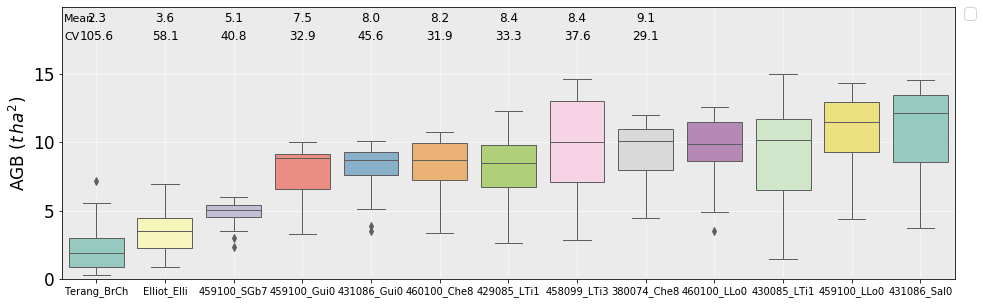

In [459]:
reorderlist = ['380074_Che8', '429085_LTi1', '459100_SGb7', '431086_Gui0',
       '459100_Gui0', 'Elliot_Elli', '430085_LTi1', '458099_LTi3',
       '460100_LLo0', '459100_LLo0', '431086_Sal0', '460100_Che8',
       'Terang_BrCh']

fig= plt.figure(figsize=(16,5))

# Apply order accordingly with mean yield
grouped = df.groupby("env")
sorted_average = pd.DataFrame({col:vals['AGB'] for col,vals in grouped}).mean().sort_values(ascending=True)
#Graph
ax=sns.boxplot(x="env", y="AGB", data=df_bow, palette="Set3", linewidth=1, order=sorted_average.index)
    
# Formatting graph and background
plt.legend(prop=dict(size=16),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{2}$)', fontsize =17)
plt.xlabel('', fontsize =17)

ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=17)
ax.set_ylim([0,19.9])
#plt.savefig('mint.png', dpi=1200)

#Specify mean
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['climate'])['AGB'].median().tolist()

y2=18.8
xposlist = range(len(yposlist))
stringlist=[sorted_average[0].round(1), sorted_average[1].round(1), sorted_average[2].round(1), sorted_average[3].round(1),
            sorted_average[4].round(1), sorted_average[5].round(1), sorted_average[6].round(1), sorted_average[7].round(1), 
            sorted_average[8].round(1)]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')

#Specify cv
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['AGB'] = df['AGB'].apply(parse)
yposlist = df.groupby(['climate'])['AGB'].median().tolist()

y2=17.5
xposlist = range(len(yposlist))
stringlist=[sorted_cv[0], sorted_cv[1], sorted_cv[2], sorted_cv[3], sorted_cv[4], sorted_cv[5], sorted_cv[6], sorted_cv[7], sorted_cv[8]]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')
    
plt.text(-0.47, 18.8, 'Mean',fontsize=11,color='k')
plt.text(-0.47, 17.5, 'CV',fontsize=11,color='k')

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\yieldvsclimate.png', dpi=300,bbox_inches='tight')

In [463]:
df_bow.groupby('soil').count()

,SimulationID,date,year,AGB,Das,rain,radn,tmax,tmin,actualET,...,SowDate,Cultivar,RowSpacing,SowDensity,EndJuv,PAWC,SimulationName,climate,cultivar,env
soil,,,,,,,,,,,,,,,,,,,,,
BrCh,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Che8,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
Elli,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Gui0,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
LLo0,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
LTi1,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
LTi3,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
SGb7,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
Sal0,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


No handles with labels found to put in legend.


Text(-0.47, 17.5, 'CV')

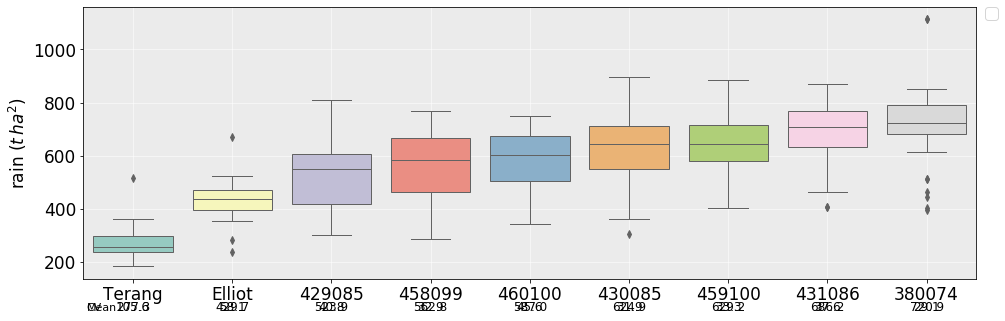

In [438]:
fig= plt.figure(figsize=(16,5))

# Apply order accordingly with mean yield
grouped = df.groupby("climate")
sorted_average = pd.DataFrame({col:vals['rain'] for col,vals in grouped}).mean().sort_values(ascending=True)
#Graph
ax=sns.boxplot(x="climate", y="rain", data=df, palette="Set3", linewidth=1, order=sorted_average.index)
    
# Formatting graph and background
plt.legend(prop=dict(size=16),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('rain ($t\,ha^{2}$)', fontsize =17)
plt.xlabel('', fontsize =17)

ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
#ax.set_ylim([0,19.9])
#plt.savefig('mint.png', dpi=1200)

#Specify mean
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['rain'] = df['rain'].apply(parse)
yposlist = df.groupby(['climate'])['rain'].median().tolist()

y2=18.8
xposlist = range(len(yposlist))
stringlist=[sorted_average[0].round(1), sorted_average[1].round(1), sorted_average[2].round(1), sorted_average[3].round(1),
            sorted_average[4].round(1), sorted_average[5].round(1), sorted_average[6].round(1), sorted_average[7].round(1), 
            sorted_average[8].round(1)]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')

#Specify cv
def parse(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

df['rain'] = df['rain'].apply(parse)
yposlist = df.groupby(['climate'])['rain'].median().tolist()

y2=17.5
xposlist = range(len(yposlist))
stringlist=[sorted_cv[0], sorted_cv[1], sorted_cv[2], sorted_cv[3], sorted_cv[4], sorted_cv[5], sorted_cv[6], sorted_cv[7], sorted_cv[8]]

for i in range(len(stringlist)):
    ax.text(xposlist[i],y2,stringlist[i],horizontalalignment='center',size='large',color='k',weight='light')
    
plt.text(-0.47, 18.8, 'Mean',fontsize=11,color='k')
plt.text(-0.47, 17.5, 'CV',fontsize=11,color='k')

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\yieldvsclimate.png', dpi=300,bbox_inches='tight')

In [372]:
#Dataframe with mean and cv
mean = pd.DataFrame([sorted_average]).transpose().round(1)
mean=mean.reset_index()
cv = pd.DataFrame([sorted_cv]).transpose().round(1)
cv=cv.reset_index()
summ=pd.merge(mean, cv, on=['index'])
summ.rename(columns={'index':'climate','0_x':'mean','0_y':'cv'}, inplace=True)
summ

,climate,mean,cv
0,Terang,277.3,NaN
1,Elliot,429.7,NaN
2,429085,523.9,NaN
3,458099,562.8,NaN
4,460100,587.0,NaN
5,430085,624.9,NaN
6,459100,629.2,NaN
7,431086,686.2,NaN
8,380074,720.9,NaN


In [421]:
df['rain_ETo'] = df['rain']/df['potentialET']

Text(0.5, 20.80000000000002, 'rain (mm)')

<Figure size 360x360 with 0 Axes>

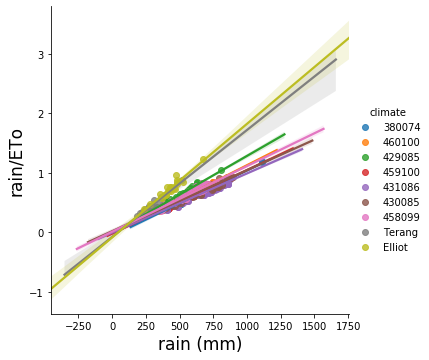

In [374]:
fig = plt.figure(figsize=(5,5))

sns.lmplot(x="rain", y="rain_ETo",hue='climate', data=df,ci=95)
# Formatting graph and background
plt.ylabel('rain/ETo', fontsize =17)
plt.xlabel('rain (mm)', fontsize =17)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\rain_ETo.png', dpi=300,bbox_inches='tight')

Text(0.5, 20.80000000000002, 'actualET (mm)')

<Figure size 360x360 with 0 Axes>

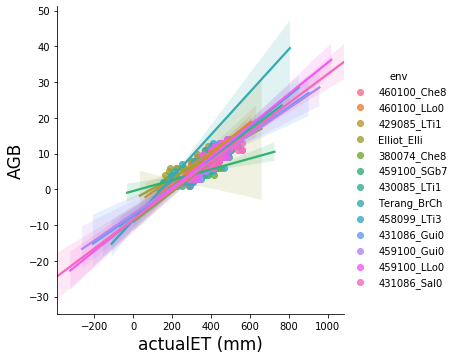

In [460]:
fig = plt.figure(figsize=(5,5))

sns.lmplot(x="actualET", y="AGB",hue='env', data=df,ci=95)
# Formatting graph and background
plt.ylabel('AGB', fontsize =17)
plt.xlabel('actualET (mm)', fontsize =17)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\rain_ETo.png', dpi=300,bbox_inches='tight')

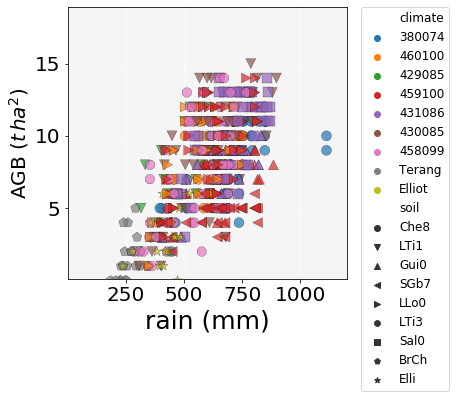

In [375]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
kwargs  =   {'edgecolor':"k"}

fig = plt.figure(figsize=(5,5))

ax=plt.subplot(1, 1, 1)

sns.scatterplot(x="rain", y="AGB",hue="climate",style="soil",s=100, alpha=0.7, data=df,linewidth=0.3,**kwargs,
                markers=filled_markers)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('AGB ($t\,ha^{2}$)', fontsize =20)
plt.xlabel('rain (mm)', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(250))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1,1199])
ax.set_ylim([0.1,18.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#plt.savefig(r'C:\Users\jjojeda\Google Drive\COALAR\Sorgo\papers\Paper 1\Figures\agbVSrain.png', dpi=300,bbox_inches='tight')

In [415]:
#Calculate statistics
summ = df_bow.groupby(['env'], as_index=False)['AGB','radn','PAWC','rain','tmax','tmin','actualET'].mean().round(decimals=1)

In [416]:
summ.describe()

,AGB,radn,PAWC,rain,tmax,tmin,actualET
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,7.369231,4019.938462,164.576923,580.461538,24.769231,11.100000,355.830769
std,2.649020,546.681910,66.469406,118.269083,2.075405,0.619139,83.898872
min,1.800000,2912.900000,107.800000,276.900000,18.600000,9.600000,174.900000
25%,7.200000,3994.700000,117.400000,580.600000,25.200000,11.000000,333.000000
50%,7.900000,4113.900000,154.000000,591.800000,25.500000,11.300000,378.500000
75%,8.900000,4400.500000,169.300000,632.900000,25.800000,11.500000,396.300000
max,10.500000,4729.900000,304.600000,722.000000,25.900000,11.800000,466.800000


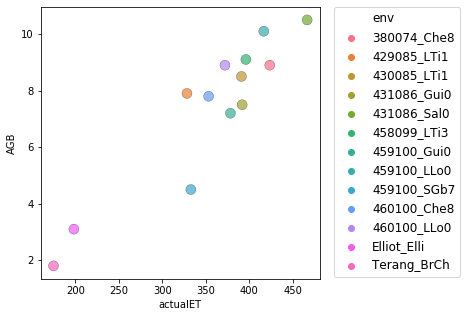

In [440]:
fig = plt.figure(figsize=(5,5))

ax=plt.subplot(1, 1, 1)

sns.scatterplot(x="actualET", y="AGB",hue='env',s=100, alpha=0.7, data=summ,linewidth=0.3,**kwargs)
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [379]:
# Original author: Thomas Haslwanter

import numpy as np
import matplotlib.pyplot as plt
import pandas

# For 3d plots. This import is necessary to have 3D plotting below
from mpl_toolkits.mplot3d import Axes3D

# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

In [380]:
df_bow.shape

(286, 22)

In [381]:
list(df_bow.columns)

['SimulationID',
 'date',
 'year',
 'AGB',
 'Das',
 'rain',
 'radn',
 'tmax',
 'tmin',
 'actualET',
 'potentialET',
 'SowDate',
 'Cultivar',
 'RowSpacing',
 'SowDensity',
 'EndJuv',
 'PAWC',
 'SimulationName',
 'climate',
 'soil',
 'cultivar',
 'env']

In [419]:
model = ols("AGB ~ actualET + rain", summ).fit()
# Print the summary
print(model.summary())

print("\nRetrieving manually the parameter estimates:")
print(model._results.params)
# should be array([-4.99754526,  3.00250049, -0.50514907])

# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)

plt.show()

                            OLS Regression Results                            
Dep. Variable:                    AGB   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     50.03
Date:                Wed, 16 Sep 2020   Prob (F-statistic):           6.19e-06
Time:                        21:47:38   Log-Likelihood:                -15.001
No. Observations:                  13   AIC:                             36.00
Df Residuals:                      10   BIC:                             37.70
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6743      1.284     -1.304      0.2

NameError: name 'PAWC' is not defined

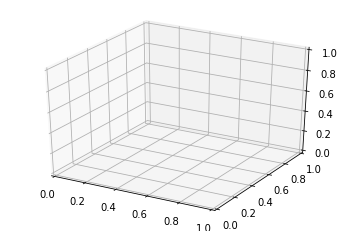

In [359]:
# Plot the data
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(PAWC.summ, AGB.summ, radn.summ, cmap=plt.cm.coolwarm,
                       rstride=1, cstride=1)
ax.view_init(20, -120)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

(1998.5, 2020.5)

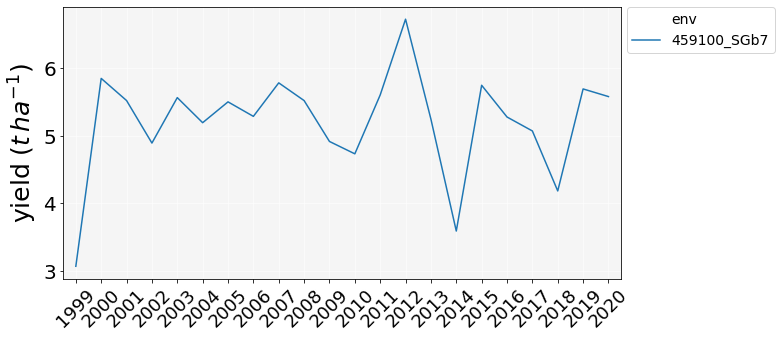

In [457]:
fig= plt.figure(figsize=(10,5))

ax=plt.subplot(1, 1, 1)

ax = sns.lineplot(x="year", y="AGB", hue='env', estimator=np.median, data=df_459100_SGb7,ci=None, err_style="band")

# Formatting graph and background
plt.legend(prop=dict(size=14),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('yield ($t\,ha^{-1}$)', fontsize =25)
plt.xlabel('', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([1998.5,2020.5])

#ax.set_title('a',fontsize= 40,weight='bold') 
#ax.title.set_position([1.03,-0.02])

#plt.savefig(r'C:\Users\jjojeda\Dropbox\DATA\scaling project\results\Paper 2\docs\Figures\years.png', dpi=300,bbox_inches='tight')